In [1]:
import numpy as np
import pandas as pd

import os
import io

import pickle # saving and loading trained model
from os import path

import matplotlib.pyplot as plt

import seaborn as sns

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import missingno as msgno # for analysing missing values

from keras.models import Sequential
from keras import callbacks
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, LSTM, RepeatVector, TimeDistributed, Input
from tensorflow.keras import Model
from sklearn import metrics

from tensorflow import keras

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import datetime as dt
import seaborn as sn

2024-12-11 17:12:39.335645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Loading datasets to 3 different data frames for analysis
dataDir = './data'
csvfiles = os.listdir(dataDir)
df = pd.DataFrame()

dFrames = []

#iterate through all the files, read it and combine the data
for fname in csvfiles:
    if(fname.split(".")[1] == 'csv'):
        df = pd.read_csv(os.path.join(dataDir, fname), low_memory=False, index_col=None, header=0)
        dFrames.append(df)
        print("Read file {}".format(fname))

df = pd.concat(dFrames, axis=0, ignore_index=True)

print("Finisehd loading files")

Read file metasploitable-2.csv
Read file Normal_data.csv
Read file OVS.csv
Finisehd loading files


### Analysisng metasploitable-2.csv

In [3]:
dFrames[0].head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.3.130-200.175.2.130-38694-4444-6,192.168.3.130,38694,200.175.2.130,4444,6,10/1/2020 5:02,269709,4,5,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,U2R
1,192.168.3.130-200.175.2.130-38693-4444-6,192.168.3.130,38693,200.175.2.130,4444,6,10/1/2020 5:02,268599,2,3,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,U2R
2,192.168.3.130-200.175.2.130-3632-33747-6,200.175.2.130,33747,192.168.3.130,3632,6,10/1/2020 5:02,22194,5,5,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,U2R
3,192.168.3.130-200.175.2.130-8180-38745-6,200.175.2.130,38745,192.168.3.130,8180,6,10/1/2020 1:39,9556,4,4,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BFA
4,192.168.3.130-200.175.2.130-8180-37217-6,200.175.2.130,37217,192.168.3.130,8180,6,10/1/2020 1:39,8782,4,4,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BFA


In [4]:
dFrames[0].shape

(136743, 84)

In [5]:
dFrames[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136743 entries, 0 to 136742
Data columns (total 84 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow ID            136743 non-null  object 
 1   Src IP             136743 non-null  object 
 2   Src Port           136743 non-null  int64  
 3   Dst IP             136743 non-null  object 
 4   Dst Port           136743 non-null  int64  
 5   Protocol           136743 non-null  int64  
 6   Timestamp          136743 non-null  object 
 7   Flow Duration      136743 non-null  int64  
 8   Tot Fwd Pkts       136743 non-null  int64  
 9   Tot Bwd Pkts       136743 non-null  int64  
 10  TotLen Fwd Pkts    136743 non-null  int64  
 11  TotLen Bwd Pkts    136743 non-null  int64  
 12  Fwd Pkt Len Max    136743 non-null  int64  
 13  Fwd Pkt Len Min    136743 non-null  int64  
 14  Fwd Pkt Len Mean   136743 non-null  float64
 15  Fwd Pkt Len Std    136743 non-null  float64
 16  Bw

In [6]:
dFrames[0].describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,136743.000000,136743.000000,136743.000000,1.367430e+05,136743.000000,136743.000000,136743.000000,136743.000000,136743.000000,136743.000000,...,136743.000000,136743.0,1.367430e+05,1.367430e+05,1.367430e+05,1.367430e+05,1.367430e+05,1.367430e+05,1.367430e+05,1.367430e+05
mean,7584.451285,11313.557747,2.796172,8.394408e+06,0.926951,3.091632,8.757662,8.173025,8.036229,0.001638,...,0.298231,0.0,1.511978e+04,4.731904e+03,2.083635e+04,1.228448e+04,8.143571e+06,1.375585e+04,8.156480e+06,8.132080e+06
std,15980.548414,17724.142526,2.994221,2.138543e+07,1.744029,1.982729,22.970945,15.063613,13.315169,0.235716,...,0.812670,0.0,2.242634e+05,1.100321e+05,2.819971e+05,2.124402e+05,2.099977e+07,3.157609e+05,2.100513e+07,2.099902e+07
min,0.000000,0.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,1.600000e+01,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.000000,0.000000,3.300000e+01,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,80.000000,33915.500000,6.000000,1.021000e+04,3.000000,4.000000,30.000000,30.000000,30.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65518.000000,58178.000000,17.000000,1.199654e+08,84.000000,87.000000,2460.000000,2498.000000,287.000000,44.000000,...,82.000000,0.0,4.575740e+06,3.366629e+06,4.807377e+06,4.575740e+06,1.200000e+08,9.274678e+06,1.200000e+08,1.200000e+08


In [7]:
dFrames[0].dtypes.value_counts()

int64      46
float64    33
object      5
dtype: int64

In [8]:
dFrames[0].isnull().sum()

Flow ID      0
Src IP       0
Src Port     0
Dst IP       0
Dst Port     0
            ..
Idle Mean    0
Idle Std     0
Idle Max     0
Idle Min     0
Label        0
Length: 84, dtype: int64

<AxesSubplot: >

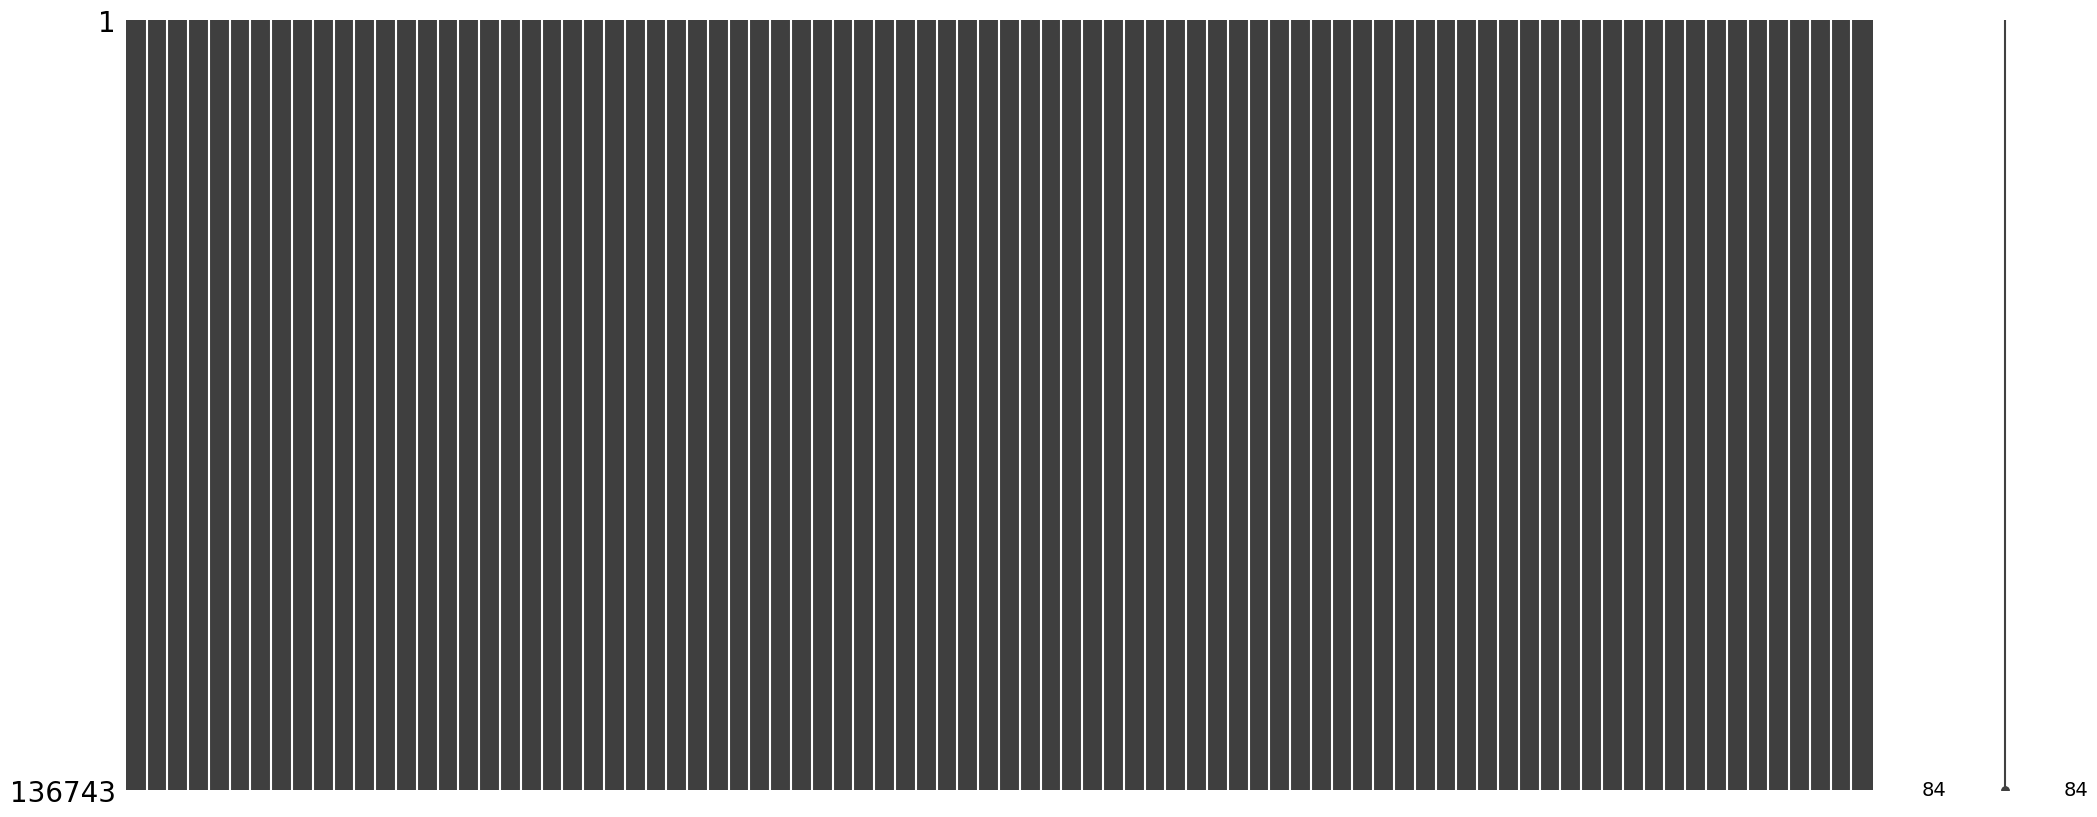

In [9]:
msgno.matrix(dFrames[0]) 

In [10]:
dFrames[0]['Label'].unique()

array(['U2R', 'BFA', 'DDoS', 'DoS', 'Probe'], dtype=object)

In [11]:
dt = pd.to_datetime(dFrames[0]['Timestamp'])

date_range = dt.min(), dt.max()

# Print the date range
print(f"Date range: {date_range[0]} to {date_range[1]}")

Date range: 2020-09-01 16:29:00 to 2020-10-01 20:57:00


In [12]:
print(dFrames[0].columns[(dFrames[0] == 0).all()])

Index(['Fwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg',
       'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg',
       'Bwd Blk Rate Avg', 'Fwd Seg Size Min'],
      dtype='object')


In [13]:
#Check for duplicates
dFrames[0][dFrames[0].duplicated()]

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label


### Analysisng Normal_data.csv

In [14]:
dFrames[1].head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,185.127.17.56-192.168.20.133-443-53648-6,185.127.17.56,443,192.168.20.133,53648,6,5/2/2020 13:58,245230,44,40,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,185.127.17.56-192.168.20.133-443-53650-6,192.168.20.133,53650,185.127.17.56,443,6,5/2/2020 13:58,1605449,107,149,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,192.168.20.133-192.168.20.2-35108-53-6,192.168.20.133,35108,192.168.20.2,53,6,5/2/2020 13:58,53078,5,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,192.168.20.133-192.168.20.2-35108-53-6,192.168.20.2,53,192.168.20.133,35108,6,5/2/2020 13:58,6975,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
4,154.59.122.74-192.168.20.133-443-60900-6,192.168.20.133,60900,154.59.122.74,443,6,5/2/2020 13:58,190141,13,16,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


In [15]:
dFrames[1].shape

(68424, 84)

In [16]:
dFrames[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68424 entries, 0 to 68423
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            68424 non-null  object 
 1   Src IP             68424 non-null  object 
 2   Src Port           68424 non-null  int64  
 3   Dst IP             68424 non-null  object 
 4   Dst Port           68424 non-null  int64  
 5   Protocol           68424 non-null  int64  
 6   Timestamp          68424 non-null  object 
 7   Flow Duration      68424 non-null  int64  
 8   Tot Fwd Pkts       68424 non-null  int64  
 9   Tot Bwd Pkts       68424 non-null  int64  
 10  TotLen Fwd Pkts    68424 non-null  float64
 11  TotLen Bwd Pkts    68424 non-null  float64
 12  Fwd Pkt Len Max    68424 non-null  int64  
 13  Fwd Pkt Len Min    68424 non-null  int64  
 14  Fwd Pkt Len Mean   68424 non-null  float64
 15  Fwd Pkt Len Std    68424 non-null  float64
 16  Bwd Pkt Len Max    684

In [17]:
dFrames[1].describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,68424.000000,68424.000000,68424.000000,6.842400e+04,68424.000000,68424.000000,6.842400e+04,6.842400e+04,68424.000000,68424.000000,...,68424.000000,68424.0,6.842400e+04,6.842400e+04,6.842400e+04,6.842400e+04,6.842400e+04,6.842400e+04,6.842400e+04,6.842400e+04
mean,37361.032459,9733.738557,11.418947,1.362636e+07,11.807217,18.592628,3.354497e+03,4.128116e+04,425.863644,22.297469,...,3.891266,0.0,1.887697e+05,1.434025e+05,3.980718e+05,8.563484e+04,4.508770e+06,6.041184e+05,5.066966e+06,3.975015e+06
std,20305.851419,19352.308798,5.551915,3.360107e+07,112.712183,235.949827,1.560998e+05,7.680108e+05,1425.400448,67.228213,...,57.082340,0.0,1.373001e+06,1.105629e+06,2.467808e+06,1.027435e+06,1.314630e+07,3.486207e+06,1.448106e+07,1.246315e+07
min,0.000000,0.000000,0.000000,-1.540000e+02,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,34213.500000,53.000000,6.000000,3.134000e+03,1.000000,2.000000,3.000000e+01,1.370000e+02,30.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,43383.000000,443.000000,6.000000,4.799000e+03,1.000000,3.000000,3.600000e+01,5.020000e+02,36.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,52105.250000,443.000000,17.000000,7.122470e+05,6.000000,5.000000,5.990000e+02,7.620000e+02,249.000000,34.000000,...,3.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65513.000000,60998.000000,17.000000,1.200000e+08,16928.000000,34094.000000,3.160000e+07,1.070000e+08,64239.000000,3900.000000,...,11180.000000,0.0,1.040000e+08,6.830000e+07,1.040000e+08,1.040000e+08,1.190000e+08,7.300000e+07,1.190000e+08,1.190000e+08


In [18]:
dFrames[1].dtypes.value_counts()

int64      41
float64    38
object      5
dtype: int64

In [19]:
dFrames[1].isnull().sum()

Flow ID      0
Src IP       0
Src Port     0
Dst IP       0
Dst Port     0
            ..
Idle Mean    0
Idle Std     0
Idle Max     0
Idle Min     0
Label        0
Length: 84, dtype: int64

<AxesSubplot: >

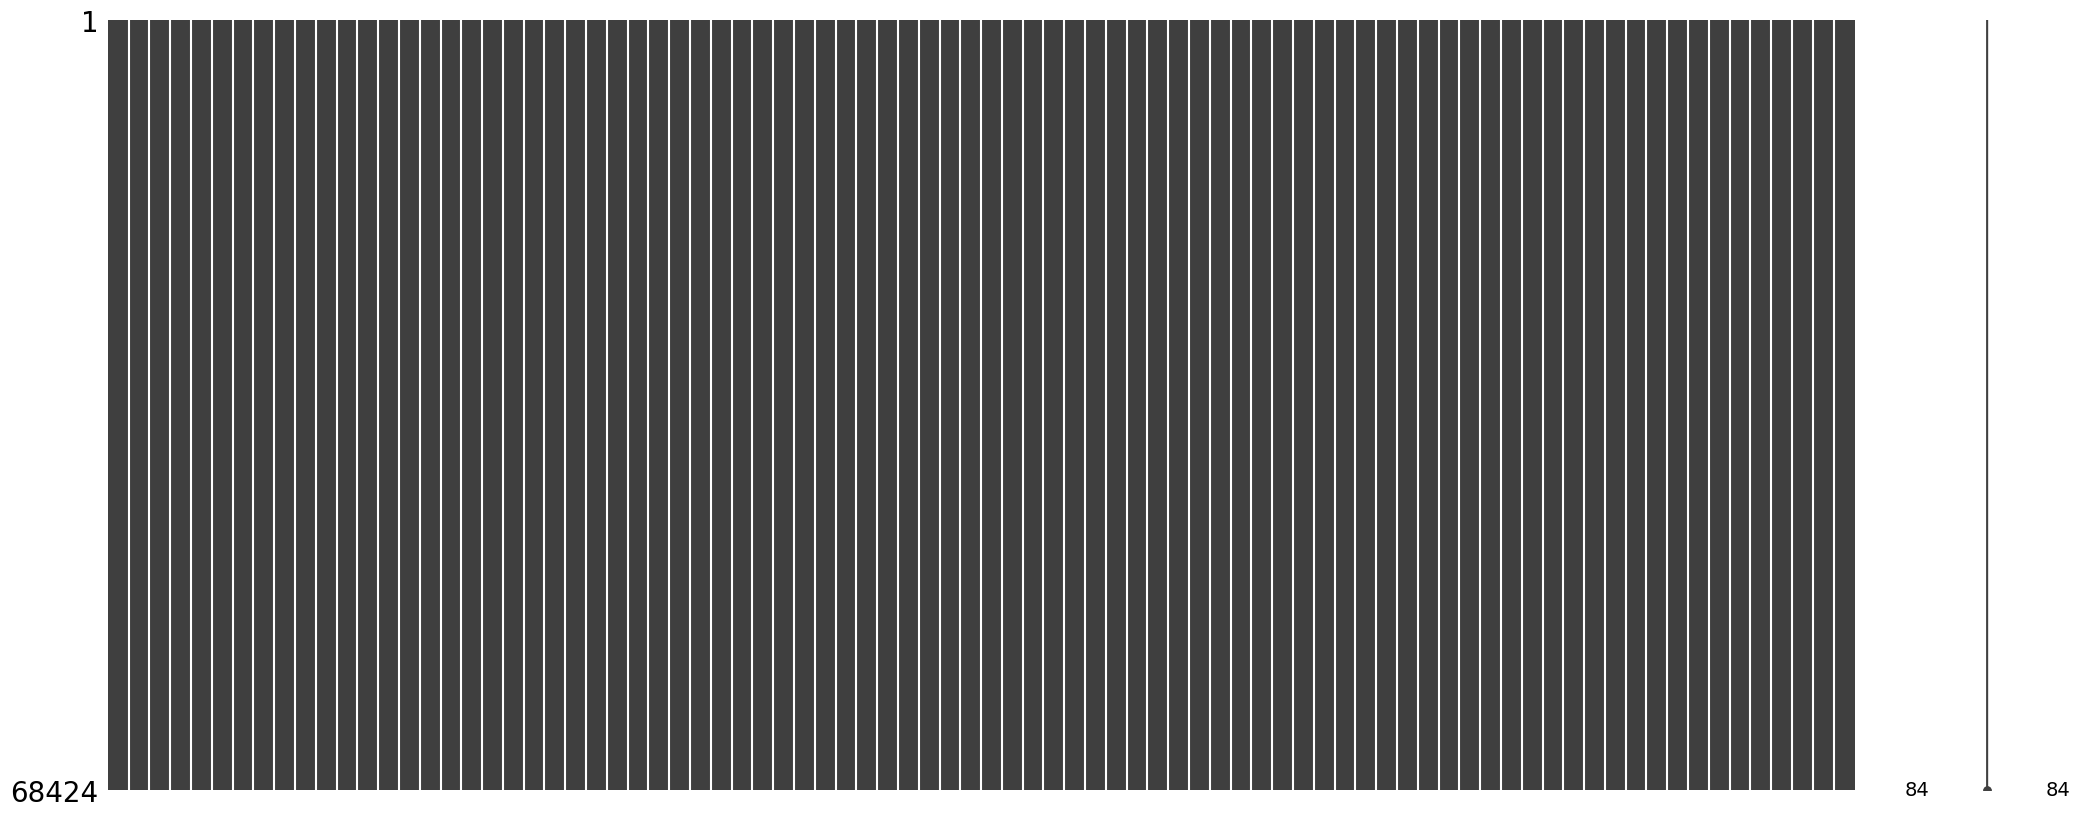

In [20]:
msgno.matrix(dFrames[1]) 

In [21]:
dFrames[1]['Label'].unique()

array(['Normal'], dtype=object)

In [22]:
dt = pd.to_datetime(dFrames[1]['Timestamp'])

date_range = dt.min(), dt.max()

# Print the date range
print(f"Date range: {date_range[0]} to {date_range[1]}")


Date range: 2019-12-31 14:25:49 to 2020-07-02 19:53:00


In [23]:
print(dFrames[1].columns[(dFrames[1] == 0).all()])

Index(['Fwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg',
       'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg',
       'Bwd Blk Rate Avg', 'Fwd Seg Size Min'],
      dtype='object')


In [24]:
#Check for duplicates
dFrames[1][dFrames[1].duplicated()]

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
34156,192.168.20.133-104.18.43.217-57398-80-6,192.168.20.133,57398,104.18.43.217,80,6,5/2/2020 12:08,-153,0,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


### Analysisng OVS.csv

In [25]:
dFrames[2].head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,172.17.0.2-200.175.2.130-80-48856-6,200.175.2.130,48856,172.17.0.2,80,6,12/1/2020 1:14,4045,2,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
1,172.17.0.2-200.175.2.130-80-48856-6,200.175.2.130,48856,172.17.0.2,80,6,12/1/2020 1:14,284,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
2,172.17.0.2-200.175.2.130-80-48858-6,200.175.2.130,48858,172.17.0.2,80,6,12/1/2020 1:14,4302,2,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
3,172.17.0.2-200.175.2.130-80-48858-6,200.175.2.130,48858,172.17.0.2,80,6,12/1/2020 1:14,83,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
4,172.17.0.2-200.175.2.130-80-48860-6,200.175.2.130,48860,172.17.0.2,80,6,12/1/2020 1:14,3760,2,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA


In [26]:
dFrames[2].shape

(138722, 84)

In [27]:
dFrames[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138722 entries, 0 to 138721
Data columns (total 84 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow ID            138722 non-null  object 
 1   Src IP             138722 non-null  object 
 2   Src Port           138722 non-null  int64  
 3   Dst IP             138722 non-null  object 
 4   Dst Port           138722 non-null  int64  
 5   Protocol           138722 non-null  int64  
 6   Timestamp          138722 non-null  object 
 7   Flow Duration      138722 non-null  int64  
 8   Tot Fwd Pkts       138722 non-null  int64  
 9   Tot Bwd Pkts       138722 non-null  int64  
 10  TotLen Fwd Pkts    138722 non-null  int64  
 11  TotLen Bwd Pkts    138722 non-null  int64  
 12  Fwd Pkt Len Max    138722 non-null  int64  
 13  Fwd Pkt Len Min    138722 non-null  int64  
 14  Fwd Pkt Len Mean   138722 non-null  float64
 15  Fwd Pkt Len Std    138722 non-null  float64
 16  Bw

In [28]:
dFrames[2].describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,138722.000000,138722.000000,138722.000000,1.387220e+05,138722.000000,138722.000000,138722.000000,138722.000000,138722.000000,138722.000000,...,138722.000000,138722.0,1.387220e+05,1.387220e+05,1.387220e+05,1.387220e+05,1.387220e+05,1.387220e+05,1.387220e+05,1.387220e+05
mean,28590.150805,4058.269092,3.911492,1.705513e+06,8.533751,2.950650,149.048759,292.504022,68.814644,0.026211,...,1.360224,0.0,5.027155e+04,1.583963e+03,5.242607e+04,4.941142e+04,1.420137e+06,4.633044e+04,1.468712e+06,1.380748e+06
std,23855.062703,11594.755381,2.877929,1.107296e+07,2445.718229,14.918974,1935.634892,741.152741,194.641622,0.962083,...,47.433114,0.0,7.341994e+05,7.711422e+04,7.476735e+05,7.325348e+05,1.024988e+07,7.443023e+05,1.036689e+07,1.020332e+07
min,0.000000,0.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,2.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,37831.000000,80.000000,6.000000,2.208000e+03,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,48394.000000,1058.000000,6.000000,7.661750e+03,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,63020.000000,65389.000000,17.000000,1.197861e+08,910748.000000,2039.000000,77600.000000,80143.000000,1448.000000,44.000000,...,2425.000000,0.0,6.810000e+07,6.092367e+06,6.810000e+07,6.810000e+07,8.220000e+07,1.780000e+07,8.220000e+07,8.220000e+07


In [29]:
#Get the summary of datatypes
dFrames[2].dtypes.value_counts()

int64      43
float64    36
object      5
dtype: int64

In [30]:
#Check for null values
dFrames[2].isnull().sum()

Flow ID      0
Src IP       0
Src Port     0
Dst IP       0
Dst Port     0
            ..
Idle Mean    0
Idle Std     0
Idle Max     0
Idle Min     0
Label        0
Length: 84, dtype: int64

<AxesSubplot: >

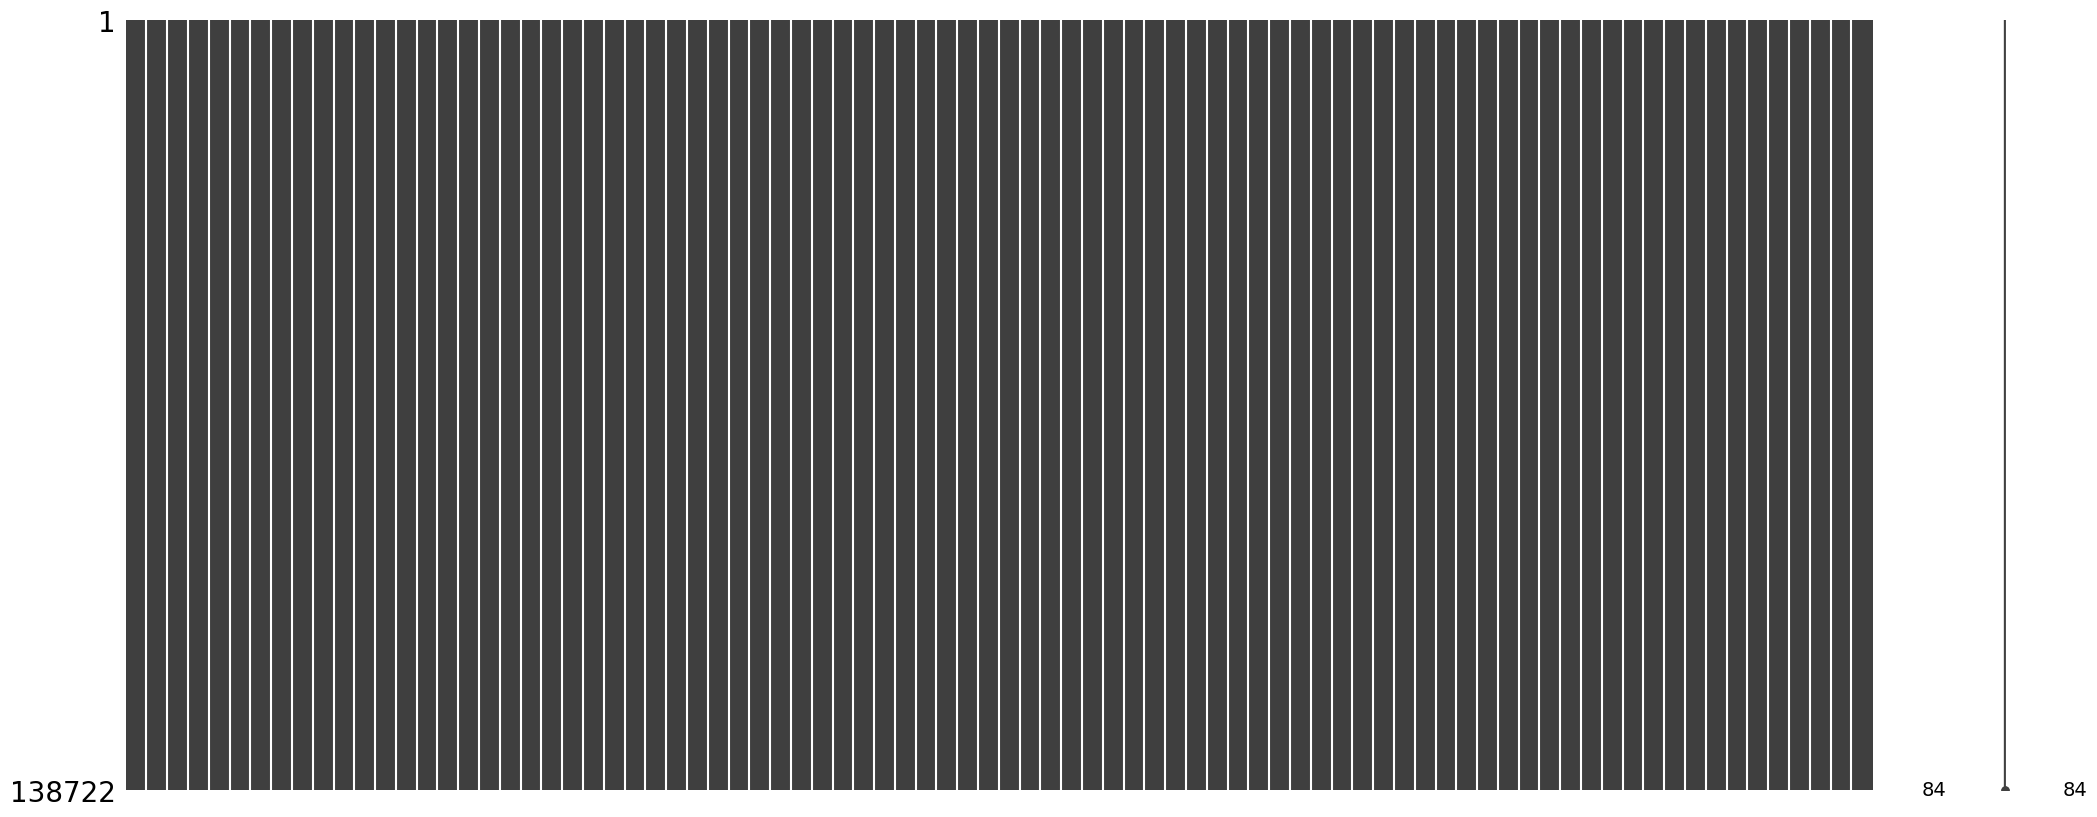

In [31]:
#Check NaN
msgno.matrix(dFrames[2]) 

In [32]:
#print unique values of Label column
dFrames[2]['Label'].unique()

array(['BFA', 'DDoS ', 'DoS', 'Probe', 'Web-Attack', 'BOTNET'],
      dtype=object)

In [33]:
dt = pd.to_datetime(dFrames[2]['Timestamp'])

date_range = dt.min(), dt.max()

# Print the date range
print(f"Date range: {date_range[0]} to {date_range[1]}")


Date range: 2019-12-25 17:16:48 to 2020-12-01 01:27:00


In [34]:
#check for all zero columns
print(dFrames[2].columns[(dFrames[2] == 0).all()])

Index(['Fwd PSH Flags', 'Fwd URG Flags', 'CWE Flag Count', 'ECE Flag Cnt',
       'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg',
       'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg',
       'Fwd Seg Size Min'],
      dtype='object')


In [35]:
#Check for duplicates
dFrames[2][dFrames[2].duplicated()]

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label


In [36]:
#Merging files
df = pd.concat(dFrames, axis=0, ignore_index=True)

In [37]:
df.shape

(343889, 84)

In [38]:
print(df.columns[(df == 0).all()])

Index(['Fwd PSH Flags', 'Fwd URG Flags', 'CWE Flag Count', 'ECE Flag Cnt',
       'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg',
       'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg',
       'Fwd Seg Size Min'],
      dtype='object')


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343889 entries, 0 to 343888
Data columns (total 84 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow ID            343889 non-null  object 
 1   Src IP             343889 non-null  object 
 2   Src Port           343889 non-null  int64  
 3   Dst IP             343889 non-null  object 
 4   Dst Port           343889 non-null  int64  
 5   Protocol           343889 non-null  int64  
 6   Timestamp          343889 non-null  object 
 7   Flow Duration      343889 non-null  int64  
 8   Tot Fwd Pkts       343889 non-null  int64  
 9   Tot Bwd Pkts       343889 non-null  int64  
 10  TotLen Fwd Pkts    343889 non-null  float64
 11  TotLen Bwd Pkts    343889 non-null  float64
 12  Fwd Pkt Len Max    343889 non-null  int64  
 13  Fwd Pkt Len Min    343889 non-null  int64  
 14  Fwd Pkt Len Mean   343889 non-null  float64
 15  Fwd Pkt Len Std    343889 non-null  float64
 16  Bw

In [41]:
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,343889.000000,343889.000000,343889.000000,3.438890e+05,343889.000000,343889.000000,3.438890e+05,3.438890e+05,343889.000000,343889.000000,...,343889.000000,343889.0,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05
mean,21982.659541,8072.495366,4.961767,6.737171e+06,6.160331,6.119012,7.310557e+02,8.335005e+03,115.689356,4.447778,...,1.441541,0.0,6.385104e+04,3.105350e+04,1.086384e+05,4.185579e+04,4.708172e+06,1.443613e+05,4.843965e+06,4.581512e+06
std,23669.464108,16275.407358,4.862608,2.183354e+07,1554.168988,105.863392,6.965289e+04,3.429719e+05,666.519811,31.285832,...,39.470056,0.0,7.852718e+05,5.035601e+05,1.220601e+06,6.672299e+05,1.616113e+07,1.653491e+06,1.641612e+07,1.604560e+07
min,0.000000,0.000000,0.000000,-1.540000e+02,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,1.700000e+01,0.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,443.000000,80.000000,6.000000,2.530000e+03,0.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,43920.000000,2495.000000,6.000000,1.208600e+04,2.000000,4.000000,3.000000e+01,3.000000e+01,30.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65518.000000,65389.000000,17.000000,1.200000e+08,910748.000000,34094.000000,3.160000e+07,1.070000e+08,64239.000000,3900.000000,...,11180.000000,0.0,1.040000e+08,6.830000e+07,1.040000e+08,1.040000e+08,1.200000e+08,7.300000e+07,1.200000e+08,1.200000e+08


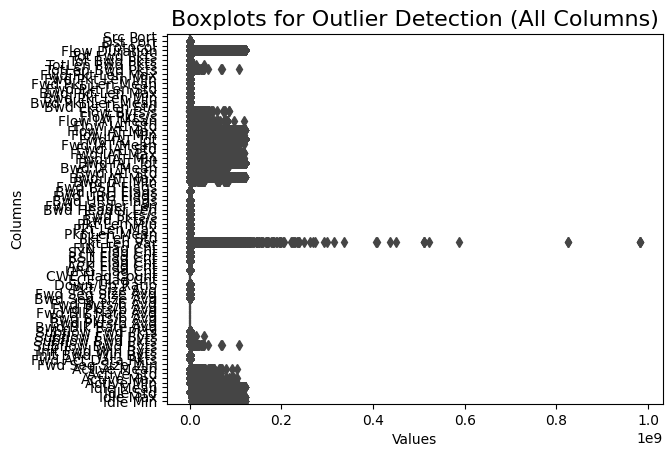

In [42]:
sns.boxplot(data=df, orient='h')

# Add title and labels
plt.title('Boxplots for Outlier Detection (All Columns)', fontsize=16)
plt.xlabel('Values')
plt.ylabel('Columns')

# Show the plot
plt.show()

In [46]:
df.shape

(343889, 84)

In [47]:
df['Label'].unique()

array(['U2R', 'BFA', 'DDoS', 'DoS', 'Probe', 'Normal', 'DDoS ',
       'Web-Attack', 'BOTNET'], dtype=object)

In [ ]:
df.loc[df['Label'] == 'DDoS ', 'Label'] = 'DDoS'

In [48]:
#Drop columns with all zero values
allZeroColumns = ['Fwd PSH Flags', 'Fwd URG Flags', 'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Fwd Seg Size Min']
df.drop(labels=allZeroColumns, axis='columns', inplace=True)

#Drop other non numeric columns
objColumns = ['Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port']
df.drop(labels=objColumns, axis='columns', inplace=True)

In [49]:
df.shape

(343889, 67)

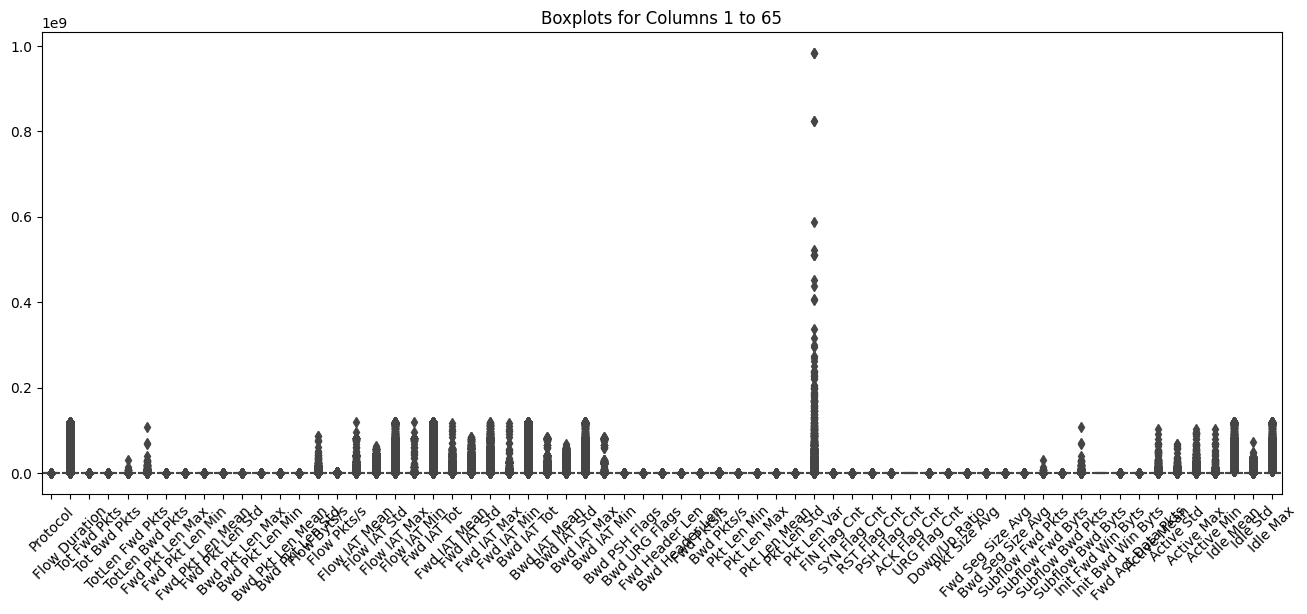

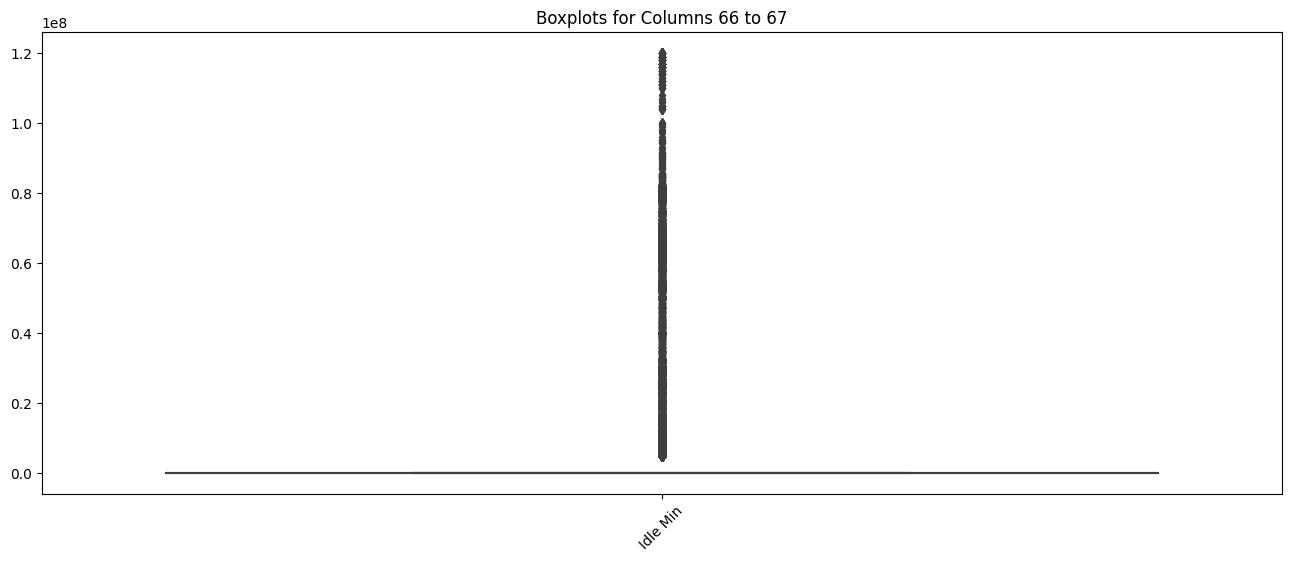

In [55]:
n_cols = df.shape[1]
subset_size = 65
for i in range(0, n_cols, subset_size):
    plt.figure(figsize=(16, 6))
    sns.boxplot(data=df.iloc[:, i:i + subset_size])
    plt.title(f'Boxplots for Columns {i+1} to {min(i+subset_size, n_cols)}')
    plt.xticks(rotation=45)
    plt.show()

In [59]:
df = df.dropna().reset_index()

labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])



In [60]:
df['Label'].unique()

array([7, 0, 2, 4, 6, 5, 3, 8, 1])

In [61]:
#X = df[:, 0:66]
data_np = df.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

enc = OneHotEncoder()
Y = enc.fit_transform(data_np[:,67:]).toarray()

In [62]:
Y.shape

(343889, 9)

In [63]:
Y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [64]:
skewness = df.skew()

In [65]:
print(skewness)

index              0.000000
Protocol           1.129431
Flow Duration      3.415788
Tot Fwd Pkts     585.169381
Tot Bwd Pkts     158.612697
                    ...    
Idle Mean          3.431857
Idle Std          15.591064
Idle Max           3.354378
Idle Min           3.499274
Label             -0.256098
Length: 68, dtype: float64


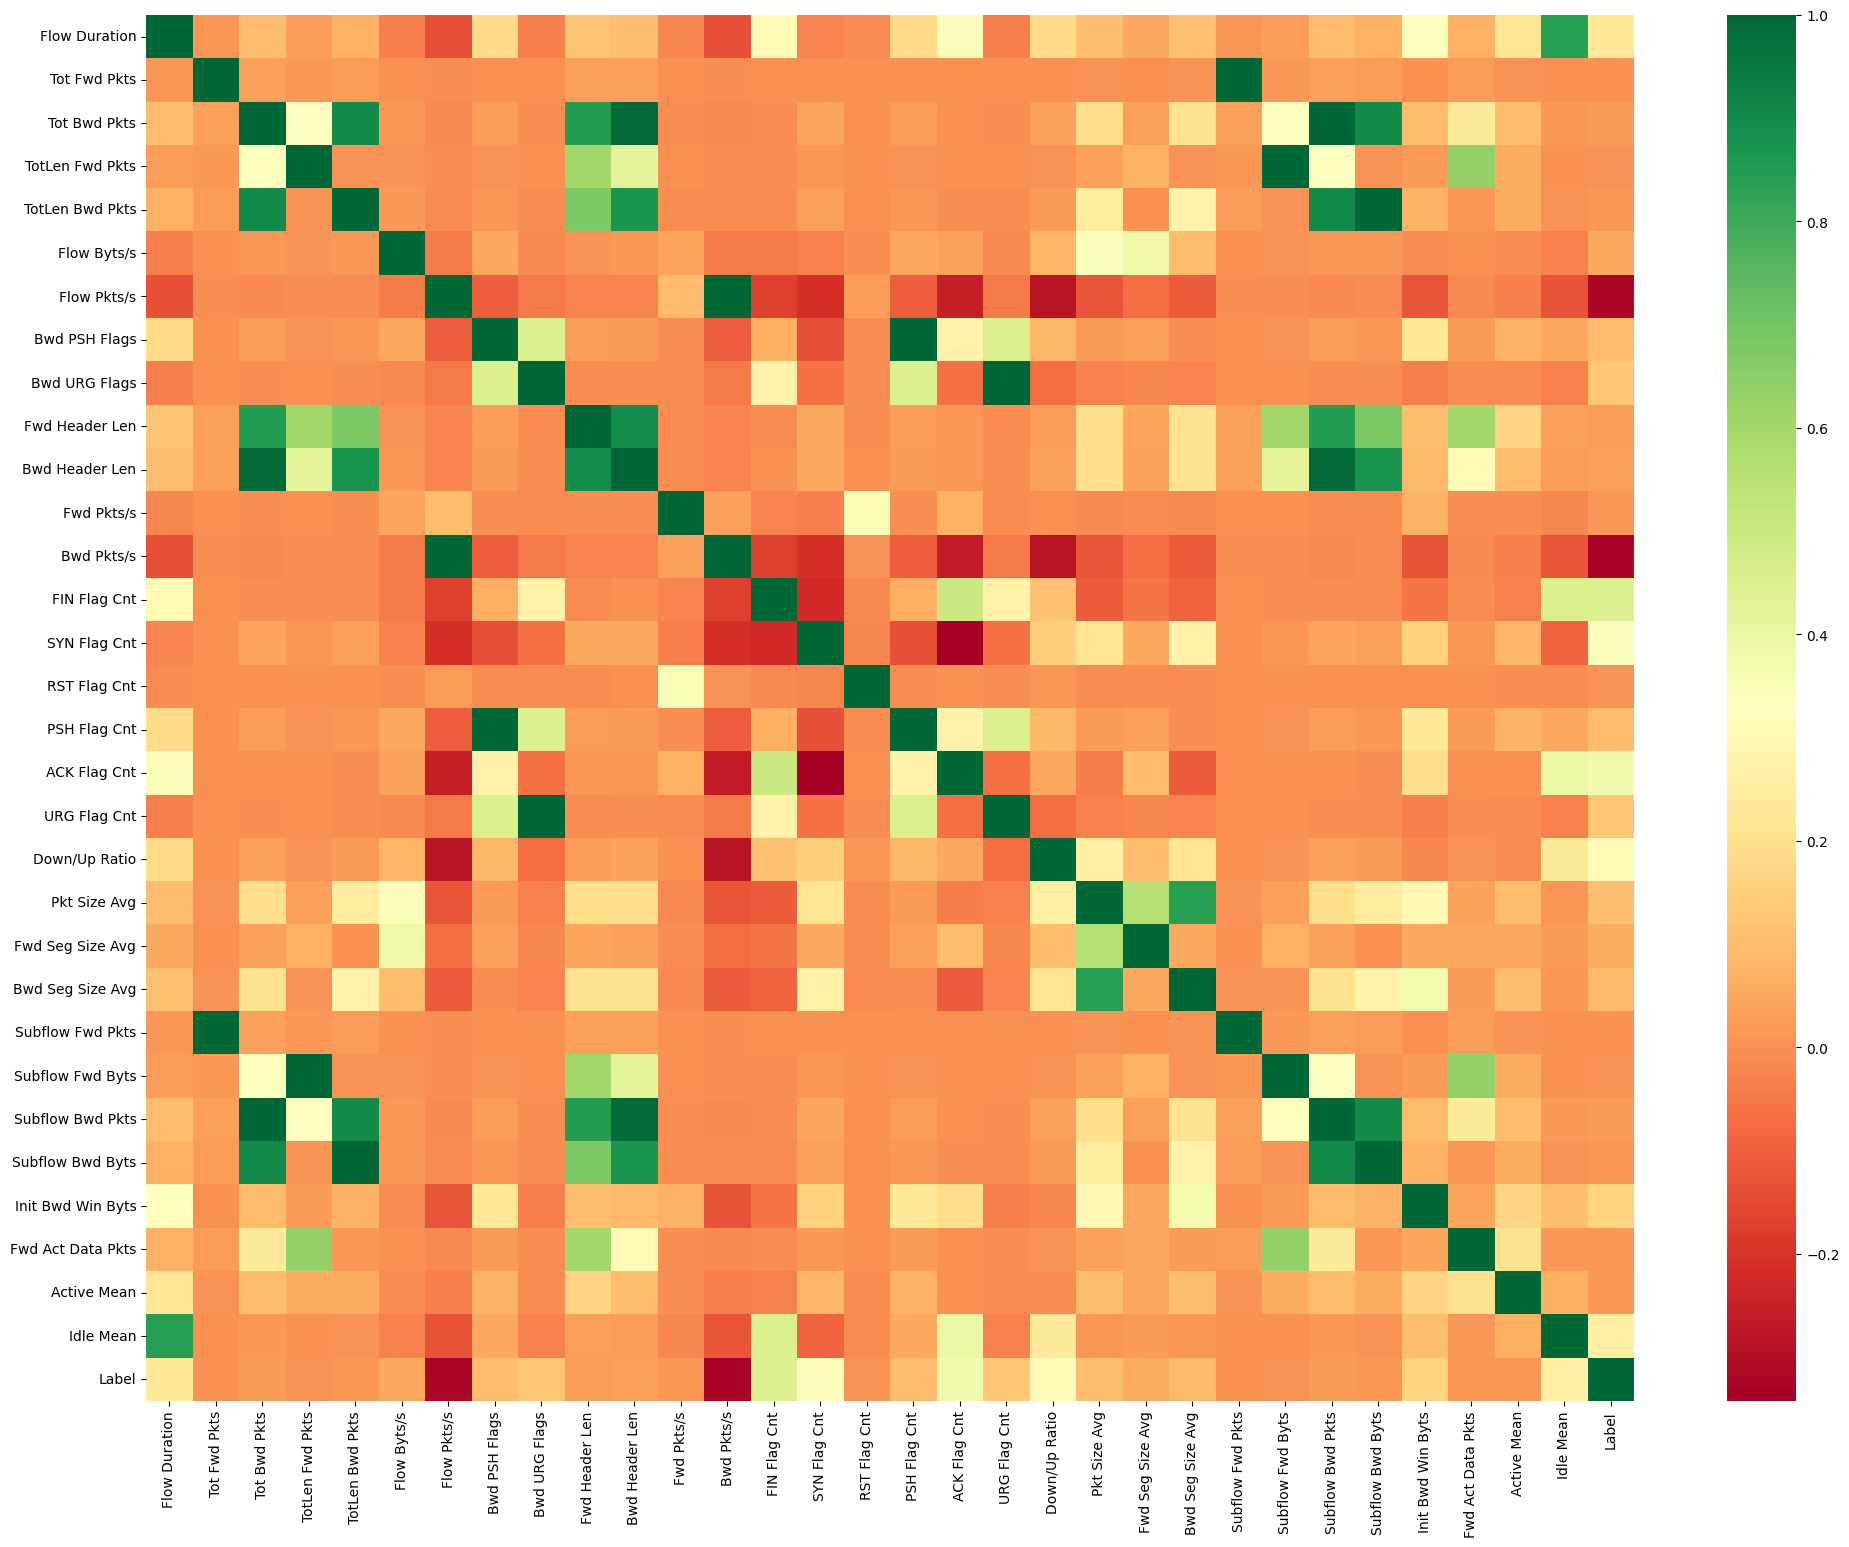

In [71]:
pd.set_option('display.max_rows', 10)
dfCorr = df[['Flow Duration','Tot Fwd Pkts','Tot Bwd Pkts','TotLen Fwd Pkts','TotLen Bwd Pkts','Flow Byts/s','Flow Pkts/s','Bwd PSH Flags','Bwd URG Flags','Fwd Header Len','Bwd Header Len','Fwd Pkts/s','Bwd Pkts/s','FIN Flag Cnt','SYN Flag Cnt','RST Flag Cnt','PSH Flag Cnt','ACK Flag Cnt','URG Flag Cnt','Down/Up Ratio','Pkt Size Avg','Fwd Seg Size Avg','Bwd Seg Size Avg','Subflow Fwd Pkts','Subflow Fwd Byts','Subflow Bwd Pkts','Subflow Bwd Byts','Init Bwd Win Byts','Fwd Act Data Pkts','Active Mean','Idle Mean','Label']]
crmat = dfCorr.corr()
plt.figure(figsize=(24,18))
sns.heatmap(crmat, cmap="RdYlGn", annot=False)
plt.show()